Author: Marie Laure, marielaure@bayesimpact.org

# IMT Market Score from API

The IMT dataset provides regional statistics about different jobs. Here we are interested in the market score (called by Pôle Emploi the tension ratio. It is a bit misleading as a big tension ratio means plenty of jobs...). It corresponds to a ratio of the average number of weekly open offers to the average number of weekly applications per 10 candidates. This value is provided among others (e.g. number of offers in the last week, number of application in the last week...) in the "statitics on offers and demands" subset of the IMT dataset.

Previously, we retrieved IMT data by scraping the IMT website. As an exploratory step, we are interested in the sanity of the API based data and identifying putative additional information provided only by the API.

The dataset can be retrieved with the following command (it takes ~15 minutes):

docker-compose run --rm data-analysis-prepare make data/imt/market_score.csv

## Data Sanity
Loading and General View
First let's load the csv file:

In [1]:
import os
from os import path

import pandas as pd
import seaborn as _

DATA_FOLDER = os.getenv('DATA_FOLDER')

market_statistics = pd.read_csv(path.join(DATA_FOLDER, 'imt/market_score.csv'))
market_statistics.head()

,AREA_CODE,AREA_NAME,AREA_TYPE_CODE,AREA_TYPE_NAME,NB_APPLICATION_END_MONTH,NB_APPLICATION_LAST_WEEK,NB_OFFER_END_MONTH,NB_OFFER_LAST_WEEK,RICHER_CATCHMENT_AREA_CODE,RICHER_CATCHMENT_AREA_NAME,...,SEASONAL_FEB,SEASONAL_JAN,SEASONAL_JULY,SEASONAL_JUNE,SEASONAL_MAR,SEASONAL_MAY,SEASONAL_NOV,SEASONAL_OCT,SEASONAL_SEP,TENSION_RATIO
0,95,VAL-D'OISE,D,Département,56,55,1,1,1101.0,TRIANGLE D OR,...,N,N,N,N,N,N,N,N,N,NaN
1,02,MARTINIQUE,R,Région,14,14,0,0,NaN,NaN,...,N,N,N,N,O,N,N,N,N,NaN
2,1101,TRIANGLE D OR,B,Bassin,235,237,80,78,NaN,NaN,...,N,N,N,O,N,O,N,N,N,35.0
3,1166,HAUTS DE SEINE CENTRE,B,Bassin,219,221,12,12,NaN,NaN,...,N,N,N,N,O,N,N,O,N,6.0
4,1189,VAL DE MARNE EST,B,Bassin,250,251,17,16,NaN,NaN,...,O,N,N,O,O,N,N,N,N,3.0


Wow! Tons of columns! There is a lot of information on whether a job is seasonal, shows a peak in offers at a particular month or not. Seasonal is described as having twice as much offers than the monthly average (calculated over a year), and seeing this pattern on two subsequent years. Because we are not interested in the seasonality here, we'll remove at least the per month data (12 columns).

In [2]:
to_remove = [name for name in market_statistics.columns if 'SEASONAL_' in name]
market_statistics.drop(to_remove, axis=1, inplace=True)
market_statistics.sort_values(['ROME_PROFESSION_CARD_CODE', 'AREA_CODE']).head()

,AREA_CODE,AREA_NAME,AREA_TYPE_CODE,AREA_TYPE_NAME,NB_APPLICATION_END_MONTH,NB_APPLICATION_LAST_WEEK,NB_OFFER_END_MONTH,NB_OFFER_LAST_WEEK,RICHER_CATCHMENT_AREA_CODE,RICHER_CATCHMENT_AREA_NAME,ROME_PROFESSION_CARD_CODE,ROME_PROFESSION_CARD_NAME,SEASONAL,TENSION_RATIO
111588,000,FRANCE ENTIERE,F,France entière,4164,4180,518,483,2203.0,SANTERRE SOMME,A1101,Conduite d'engins agricoles et forestiers,N,5.0
38169,01,GUADELOUPE,R,Région,89,89,3,2,103.0,MARIE-GALANTE,A1101,Conduite d'engins agricoles et forestiers,O,NaN
69864,01,AIN,D,Département,8,8,2,1,8247.0,VILLEFRANCHE,A1101,Conduite d'engins agricoles et forestiers,O,NaN
194659,0101,SAINTE-ROSE,B,Bassin,13,13,0,0,NaN,NaN,A1101,Conduite d'engins agricoles et forestiers,N,NaN
244409,0102,BASSE-TERRE,B,Bassin,0,0,0,0,NaN,NaN,A1101,Conduite d'engins agricoles et forestiers,N,NaN


OK. Some values are missing for Market score, documentation states that the ratio is undefined when offers and demands are below 30.

How many missing values do we have for tension ratio here?

In [3]:
market_statistics.TENSION_RATIO.notnull().describe()

count     247150
unique         2
top        False
freq      215137
Name: TENSION_RATIO, dtype: object

Data is missing for 87% of the lines!

Lines represents data for an Area x Rome job group. So how many lines should we expect? First, how many areas, area types and job groups do we have?

In [4]:
market_statistics[['ROME_PROFESSION_CARD_CODE', 'AREA_CODE', 'AREA_TYPE_CODE']].describe()

,ROME_PROFESSION_CARD_CODE,AREA_CODE,AREA_TYPE_CODE
count,247150,247150,247150
unique,532,509,4
top,D1212,44,B
freq,527,1064,182963


Oh! Look at the job groups... even the [most recent ROME job groups](https://github.com/bayesimpact/bob-emploi-internal/blob/431a44c190ca7bf11d42e84922c4dbcde74fd802/data_analysis/notebooks/datasets/rome/update_from_v331_to_v332.ipynb) groups are here! Good job Pôle Emploi! There are 4 area types (consistent with the documentation) and 509 areas.

Because some areas may be labelled with multiple area types, let's see how many area x area types we have here.

In [5]:
pd.concat([market_statistics['AREA_TYPE_CODE'], market_statistics['AREA_CODE']]).nunique()

513

A little bit more than the 509 unique area names. Thus, confirming the redundant area names describing more than one area types.

With this in mind, we would expect `509 x 532 = 272916` lines if there were information on each job in each area. Hmmm... That's not the case and we have ~9.5% of the expected lines missing.

For the remaining 32013 (~11.7% of the expected lines) lines with market score data, what is the distribution of these scores?

In [6]:
market_with_score = market_statistics[market_statistics.TENSION_RATIO.notnull()]
market_with_score.TENSION_RATIO.describe()

count    32013.000000
mean         7.345547
std         14.817923
min          0.000000
25%          3.000000
50%          5.000000
75%          8.000000
max       1664.000000
Name: TENSION_RATIO, dtype: float64

On the subset with market score information, the market score is usually between 3 and 8. Which is not super reassuring on a candidate point of view... we should remember that this corresponds to the number of offer per 10 candidates. At the end, most of the time we have less than 1 offer per candidate.

However, in some markets (area/job) we can find extreme values (the max is at 1664 offers for 10 persons). How many of these extreme/unexpected values can we found, and to which jobs and areas do they correspond?

,TENSION_RATIO,ROME_PROFESSION_CARD_NAME,AREA_NAME,SEASONAL
236886,1664.0,Animation de vente,HAUTS DE SEINE SUD,O
73617,807.0,Animation de vente,HAUTS-DE-SEINE,O
235104,549.0,Maintenance d'aéronefs,PARIS,N
69305,383.0,Enseignement général du second degré,TRIANGLE D OR,N
3597,377.0,Boulangerie - viennoiserie,PAYS D ARLES,N


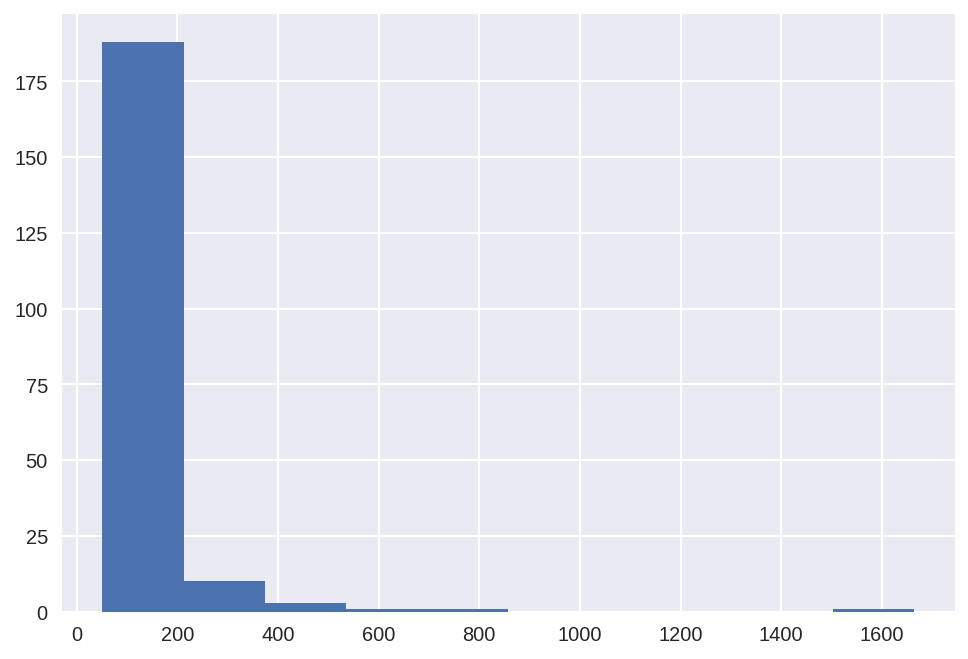

In [7]:
market_with_score[market_with_score.TENSION_RATIO > 50].TENSION_RATIO.hist();
market_with_score[market_with_score.TENSION_RATIO > 50]\
    .sort_values('TENSION_RATIO', ascending=False)\
    [['TENSION_RATIO', 'ROME_PROFESSION_CARD_NAME', 'AREA_NAME', 'SEASONAL']].head()

The 1664 offers for 10 persons observed above appears to be a real outlier. However, it corresponds to a seasonal job and may be linked to a specific place recruiting tons of people (mall, resort...). Note that it sounds like a great idea to apply to be a baker in Arles!

We noticed that the `AREA_TYPE_NAME` variable can cover multiple values. Can we say more about this?

In [8]:
market_statistics.AREA_TYPE_NAME.value_counts()

Bassin            182963
Département        54366
Région              9289
France entière       532
Name: AREA_TYPE_NAME, dtype: int64

This dataset have multiple granularity layers. We have information at the department ("Département") level, region level or whole country! 

For one job, can you have observations for multiple areas? Let's try for butchers in the "Lyon" area, the department is Rhône and the region Auvergne-Rhône-Alpes.

In [9]:
market_statistics[
    (market_statistics.AREA_NAME == 'LYON CENTRE') &\
    (market_statistics.ROME_PROFESSION_CARD_NAME == 'Boucherie')]\
    [['AREA_TYPE_NAME', 'ROME_PROFESSION_CARD_NAME', 'AREA_NAME', 'TENSION_RATIO']]

,AREA_TYPE_NAME,ROME_PROFESSION_CARD_NAME,AREA_NAME,TENSION_RATIO
128326,Bassin,Boucherie,LYON CENTRE,10.0


In [10]:
market_statistics[
    (market_statistics.AREA_NAME == 'RHONE') &\
    (market_statistics.ROME_PROFESSION_CARD_NAME == 'Boucherie')]\
    [['AREA_TYPE_NAME', 'ROME_PROFESSION_CARD_NAME', 'AREA_NAME', 'TENSION_RATIO']]

,AREA_TYPE_NAME,ROME_PROFESSION_CARD_NAME,AREA_NAME,TENSION_RATIO
3265,Département,Boucherie,RHONE,6.0


In [11]:
market_statistics[
    (market_statistics.AREA_NAME == 'AUVERGNE-RHONE-ALPES') &\
    (market_statistics.ROME_PROFESSION_CARD_NAME == 'Boucherie')]\
    [['AREA_TYPE_NAME', 'ROME_PROFESSION_CARD_NAME', 'AREA_NAME', 'TENSION_RATIO']]

,AREA_TYPE_NAME,ROME_PROFESSION_CARD_NAME,AREA_NAME,TENSION_RATIO
236560,Région,Boucherie,AUVERGNE-RHONE-ALPES,6.0


Good! We have info for all of these.

Let's go a little bit more general. How many jobs do we have here?

In [12]:
market_statistics.ROME_PROFESSION_CARD_CODE.nunique()

532



How many of these are represented in each area. If we have data for every job in every area, we expect to have 532 jobs in each area.

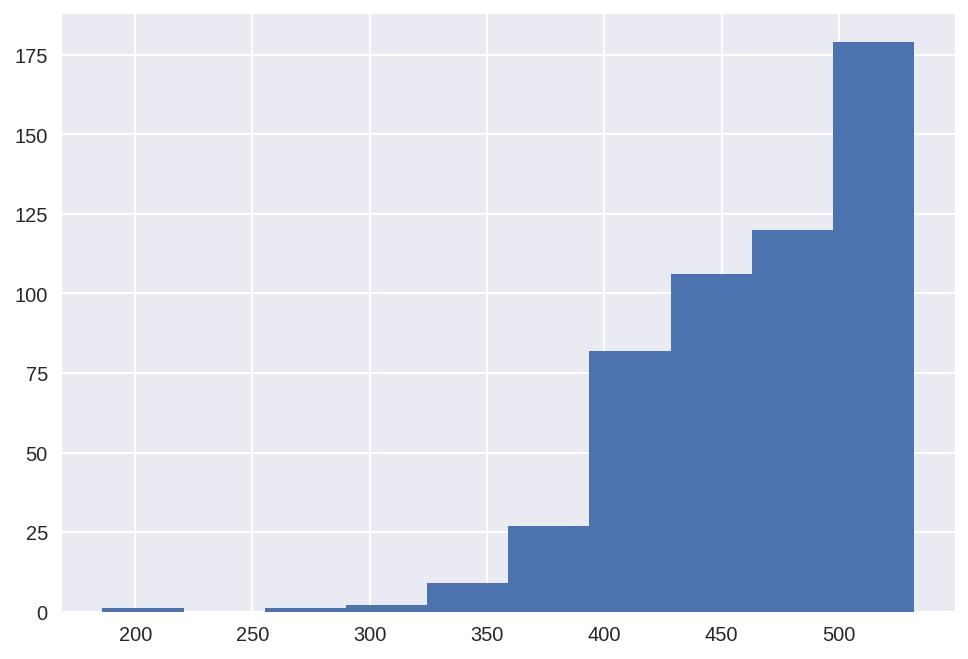

In [13]:
area_romes = market_statistics.groupby(['AREA_TYPE_CODE', 'AREA_CODE']).ROME_PROFESSION_CARD_NAME.size()
area_romes.hist();

For some areas, we have missing jobs. They could be missing because some jobs have 0 offers, 0 applications etc... 

Can we find some of these zero values in the dataset?

In [14]:
market_statistics[(market_statistics.NB_APPLICATION_END_MONTH == 0) &\
                  (market_statistics.NB_OFFER_END_MONTH == 0) &\
                  (market_statistics.NB_OFFER_LAST_WEEK == 0) &\
                  (market_statistics.NB_APPLICATION_LAST_WEEK  == 0)].head()

,AREA_CODE,AREA_NAME,AREA_TYPE_CODE,AREA_TYPE_NAME,NB_APPLICATION_END_MONTH,NB_APPLICATION_LAST_WEEK,NB_OFFER_END_MONTH,NB_OFFER_LAST_WEEK,RICHER_CATCHMENT_AREA_CODE,RICHER_CATCHMENT_AREA_NAME,ROME_PROFESSION_CARD_CODE,ROME_PROFESSION_CARD_NAME,SEASONAL,TENSION_RATIO
121,2420,GIEN,B,Bassin,0,0,0,0,NaN,NaN,E1101,Animation de site multimédia,N,NaN
146,976,MAYOTTE,D,Département,0,0,0,0,NaN,NaN,E1101,Animation de site multimédia,N,NaN
280,2609,MACON,B,Bassin,0,0,0,0,NaN,NaN,D1105,Poissonnerie,O,NaN
294,5322,QUIMPER,B,Bassin,0,0,0,0,NaN,NaN,B1604,Réparation - montage en systèmes horlogers,N,NaN
295,5326,COMBOURG,B,Bassin,0,0,0,0,NaN,NaN,B1604,Réparation - montage en systèmes horlogers,N,NaN


There are jobs with zeros and NA. So probably, the missing values and the zeros are different things. We couldn't find any information about this in the [documentation](https://www.emploi-store-dev.fr/portail-developpeur-cms/home/catalogue-des-api/documentation-des-api/api-infotravail-v1/api-infotravail-imt/statistiques-offres-demandes.html).

Is there an area level (except whole country) for which we have info for all job groups?

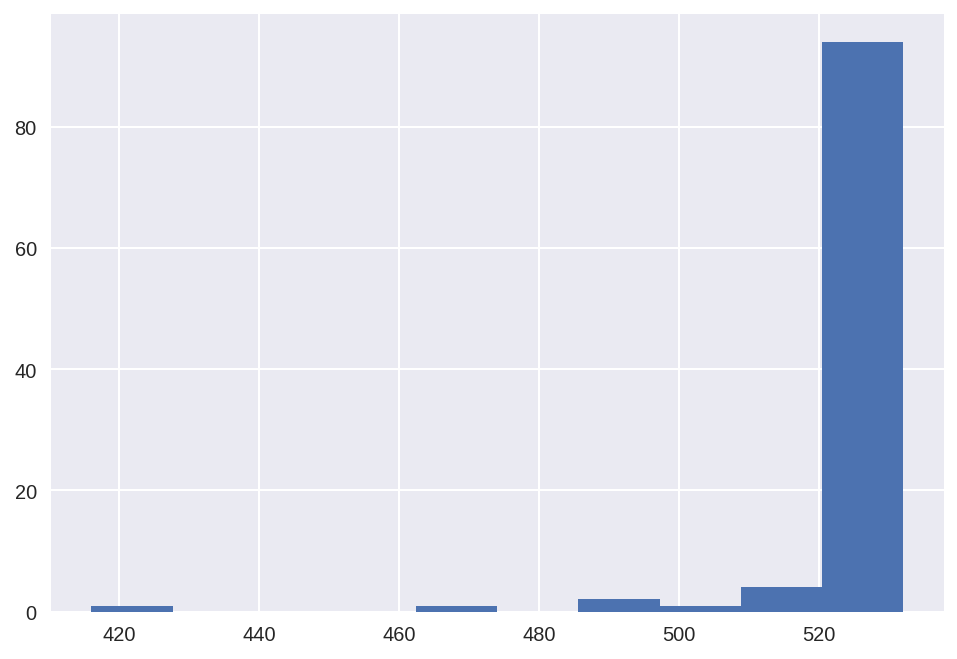

In [15]:
department_romes = market_statistics[market_statistics.AREA_TYPE_CODE == 'D'].\
    groupby('AREA_NAME').ROME_PROFESSION_CARD_NAME.size()
department_romes.hist();

Arf... Almost... A couple of departments have some jobs not represented.

Let's see with the region.

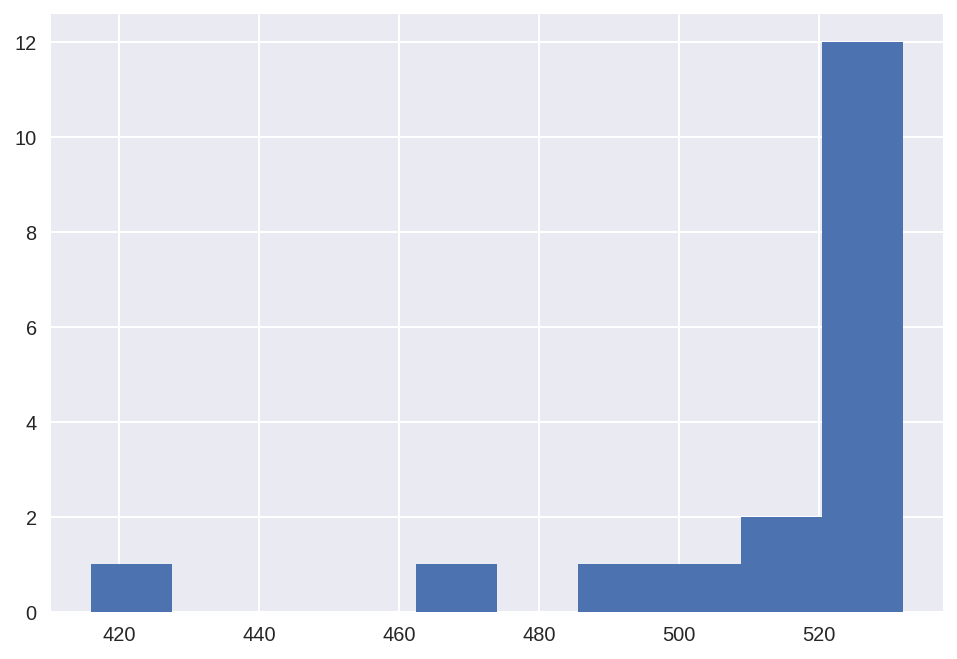

In [16]:
region_romes = market_statistics[market_statistics.AREA_TYPE_CODE == 'R'].\
    groupby('AREA_NAME').ROME_PROFESSION_CARD_NAME.size()
region_romes.hist();

Nothing is perfect! But most of the regions have information for all jobs.

Let's have a look to an area for which there is less jobs than expected (532)?
First, what are the areas with less than 532 job groups?

In [17]:
area_romes = area_romes.to_frame()
area_romes = area_romes.reset_index(['AREA_TYPE_CODE', 'AREA_CODE'])
area_romes.columns = [['AREA_TYPE_CODE', 'AREA_CODE', 'jobgroups']]
department_romes = area_romes[area_romes.AREA_TYPE_CODE == 'D']
department_romes.sort_values('jobgroups').head(10)

,AREA_TYPE_CODE,AREA_CODE,jobgroups
505,D,976,416
503,D,973,473
433,D,2A,495
434,D,2B,495
502,D,972,503
507,D,978,510
506,D,977,510
501,D,971,510
504,D,974,518
475,D,70,529


Overseas territories (97X area codes) and Corsica (2X area codes) are the areas where there are the higher number of job groups missing.

## Conclusion
This dataset seems quite clean even if:
- There are few information on market score
- There are some areas with missing jobs. This seems not to be related with lines with zeros...
However, there are multiple granularity layers that seems consistent between each others.

## Comparison with Scraped Data

Let's compare these data from the one that are now (2017/09/14) online.
For a [Nurse in the department "Yonne"](http://candidat.pole-emploi.fr/marche-du-travail/informationssurunmetier?codeMetier=38859&codeZoneGeographique=89&typeZoneGeographique=DEPARTEMENT), there are no value.

In [18]:
market_statistics[
    (market_statistics.AREA_NAME == 'YONNE') &\
    (market_statistics.ROME_PROFESSION_CARD_CODE == 'J1502')]\
    [['AREA_TYPE_NAME', 'ROME_PROFESSION_CARD_NAME', 'AREA_NAME', 'TENSION_RATIO']]

,AREA_TYPE_NAME,ROME_PROFESSION_CARD_NAME,AREA_NAME,TENSION_RATIO
84149,Département,Coordination de services médicaux ou paramédicaux,YONNE,NaN


Same here!

What about a plumber in the Cher department. The website announces [3 offers for 10 people](http://candidat.pole-emploi.fr/marche-du-travail/informationssurunmetier?codeMetier=17837&codeZoneGeographique=18&typeZoneGeographique=DEPARTEMENT).

In [19]:
market_statistics[
    (market_statistics.AREA_NAME == 'CHER') &\
    (market_statistics.ROME_PROFESSION_CARD_CODE == 'F1603')]\
    [['AREA_TYPE_NAME', 'ROME_PROFESSION_CARD_NAME', 'AREA_NAME', 'TENSION_RATIO']]

,AREA_TYPE_NAME,ROME_PROFESSION_CARD_NAME,AREA_NAME,TENSION_RATIO
135082,Département,Installation d'équipements sanitaires et therm...,CHER,3.0


Same story here. Yippee! 

Let's have a look to the areas with missing jobs. As an example we'll look at the Haute-Saône department (code 70).

In [20]:
haute_saone_jobs = market_statistics[market_statistics.AREA_CODE == '70'].ROME_PROFESSION_CARD_NAME.unique()
market_statistics[-market_statistics.ROME_PROFESSION_CARD_NAME.isin(haute_saone_jobs)].\
    ROME_PROFESSION_CARD_NAME.unique()

array(["Conservation et reconstitution d'espèces animales",
       'Encadrement équipage de la pêche',
       "Films d'animation et effets spéciaux"], dtype=object)

Online, the "Films d'animation et effets spéciaux" values are specified as [insufficient data](http://candidat.pole-emploi.fr/marche-du-travail/statistiques?codeMetier=39030&codeZoneGeographique=70&typeZoneGeographique=DEPARTEMENT).

### Conclusion
Scraped data and data provided by the API are similar. 
A [previous overview](https://github.com/bayesimpact/bob-emploi-internal/blob/HEAD/data_analysis/notebooks/research/reorientation/average_market_stress.ipynb) of the scraped data observed a market score median of 4 jobs for 10 candidates. Here we observed it at 5 jobs per 10 candidates.

## General Conclusion
This dataset gives various information on job offers and demands at multiple area level (from very local to national). It covers all the 532 job groups. We noticed that some jobs are missing at certain area levels and that this seems different from zero information. We should go back to Pôle Emploi with this question.

When focusing only on the market score we observed a majority of missing values probably due to the low average number of offers and demands.
Nevertheless, as compared to the scraped data, we have now access to deeper and larger area types ("Country" and "Bassin" in addition to "Department" and "Région"). Furthermore, the data is clean enough to recommend to
- Switch to the API data and drop the scraped data
- Explore using the data at different levels
